# Analysis of the primary energy consumption of the USA since 1850

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from math import *
import numpy as np

This data was gathered from ‘‘Estimated Energy Consumption in the United States, Selected Years, 1635–1945’’ (EIA 2011) and ‘‘Energy Consumption, Expenditures, and Emissions Indicators, 1949–2012’’ (EIA 2012)

In [2]:
USA = pd.read_csv('../BDD/USA-1850-2008.csv', sep=';')
USA=USA.dropna()
USA.head()

,Year,TotPEC(QuadrillionBTU),GDP(1990GK$),Pop(000)
0,1850.0,2.357,42583.0,23579.7179
1,1860.0,3.162,69346.0,31838.9007
2,1870.0,3.952,98374.0,40240.6295
3,1875.0,4.323,117573.0,45245.0000
4,1880.0,5.001,160656.0,50458.0000


## S-curve Model of Relationship Between Energy Consumption and Economic Development (Wang et Al, 2014)

In [3]:
PEC = USA['TotPEC(QuadrillionBTU)']*(2.518272*10**4)
GDP = USA['GDP(1990GK$)']*1000
pop = USA['Pop(000)']

In [4]:
def wang(G) :
    E=5.7+5.6*(exp(8*(10**-5)*(G-9600))-exp(-1.05*(10**-4)*(G-9600)))/(2*cosh(1.12*(10**-4)*(G-9600)))
    return E


Text(0, 0.5, 'per Capita energy consumption,Toe')

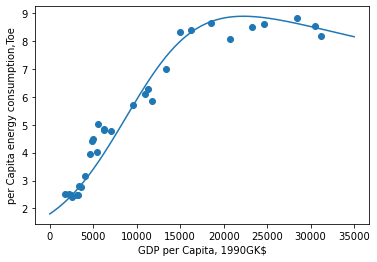

In [5]:
plt.scatter(GDP/pop, PEC/pop)
plt.plot(np.arange(35000), [wang(G) for G in np.arange(35000)])
plt.xlabel('GDP per Capita, 1990GK$')
plt.ylabel('per Capita energy consumption,Toe')

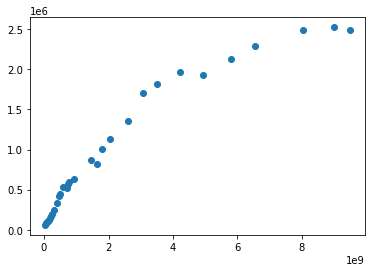

In [6]:
plt.scatter(GDP, PEC)

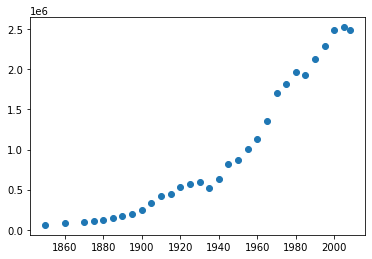

In [7]:
plt.scatter(USA['Year'], PEC )

In [8]:
def inflexion_point(E, G) : 
    n= len(E)
    delta = []
    for i in range (0, n-2) :
        delta.append((E[i+2]-2*E[i+1]+E[i])/(G[i+1]-G[i])**2)
    return delta


In [9]:
delta = inflexion_point(GDP/pop, PEC/pop)

5.200170017836462e+19
<ipython-input-36-d2509cb69390>:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
<ipython-input-36-d2509cb69390>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


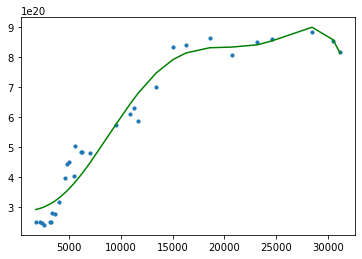

array([[ 0.00000000e+00,  2.21630138e+07,  1.92934917e+05,
         1.01188741e+09, -1.01483014e+05,  3.57929486e+00,
        -4.32184333e-05]])

In [36]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

x = GDP/pop
y = PEC/pop*10**20
x = x[:, np.newaxis]
y = y[:, np.newaxis]
polynomial_features= PolynomialFeatures(degree=6)
x_poly = polynomial_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
#r2 = r2_score(y,y_poly_pred)
print(rmse)
#print(r2)
import operator
plt.scatter(x, y, s=10)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x_p, y_poly_pred_P = zip(*sorted_zip)
plt.plot(x_p, y_poly_pred_P, color='g')
plt.show()
model.coef_

In [37]:
reg_label = "Inliers coef:%s - b:%0.2f" % \
            (np.array2string(model.coef_,
                             formatter={'float_kind': lambda fk: "%.3f" % fk}),
            model.intercept_)
print(reg_label)

Inliers coef:[[0.000 22163013.849 192934.917 1011887414.395 -101483.014 3.579 -0.000]] - b:286886685916872507392.00


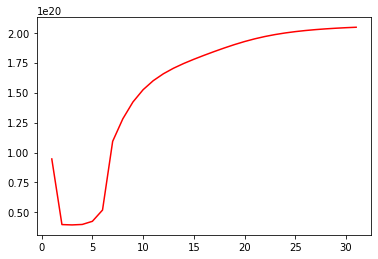

In [30]:
def degreeChoice (x,y,degree):
    polynomial_features= PolynomialFeatures(degree=degree)
    x_poly = polynomial_features.fit_transform(x)
    model = LinearRegression()
    model.fit(x_poly, y)
    y_poly_pred = model.predict(x_poly)
    rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
    x_p, y_poly_pred_P = zip(*sorted_zip)
    return rmse, x_p, y_poly_pred_P
 
rmselist = np.zeros(31)
x_p_list = [None]*31
y_poly_pred_P_list=[None]*31
for i in np.arange(1, 32):
     
    rmselist[i-1] ,x_p_list[i-1],y_poly_pred_P_list[i-1]= degreeChoice (x,y,i)
     
plt.plot(np.arange(1, 32), rmselist, color='r')
plt.show()

In [38]:
x_test = np.arange(0,35000,0.1)

x_test = x_test[:, np.newaxis]
x_poly_test = polynomial_features.fit_transform(x_test)
y_poly_pred_test = model.predict(x_poly_test)
y_poly_pred_test = np.array([y_poly_pred_test[i][0] for i in range(len(y_poly_pred_test))])

In [39]:
inflexion_point_1 = np.diff(y_poly_pred_test).argmin()
inflexion_point_2 = np.diff(y_poly_pred_test).argmax()
zero_growth = np.abs(np.diff(y_poly_pred_test[inflexion_point_2:])).argmin()
inflexion_point_2

88574

In [40]:
import math as math
def f(A, eth_1, eth_2, eth_3) :
    return math.tanh(eth_1/A)*math.tanh(eth_2/A)-eth_3

def find_A(A_min, A_max, eth_1, eth_2, eth_3, epsilon=10**-3) :
    while A_max-A_min > epsilon :
        A = (A_min+A_max)/2
        if f(A, eth_1, eth_2, eth_3) ==0 :
            return A  
        elif f(A_min, eth_1, eth_2, eth_3)*f(A_max, eth_1, eth_2, eth_3)< 0:
            A_max =A
        else :
            A_min = A

    return (A_min+A_max)/2

In [41]:
import sympy as sy
def remarking_points(G, E, deg = 6, step = 0.1) : 
    """
    This function returns the inflexion point, the zero_growth point and the take-off point of f where (f(g) = e) thanks to the data points
    degree: int, degree of the polynomial regression, default value 6 
    step: step used for the estimation of the inflexion point 
    """
    # regression of a polynomial function
    G = G[:, np.newaxis]
    E = E[:, np.newaxis]
    polynomial_features= PolynomialFeatures(degree=deg)
    G_poly = polynomial_features.fit_transform(G)
    model = LinearRegression()
    model.fit(G_poly, E)
    y_poly_pred = model.predict(x_poly) 

    # computing numerous points to improve our prediction
    max_gdp = np.amax(np.array(G))
    G_calc = np.arange(0, max_gdp, step)
    G_calc = G_calc[:, np.newaxis]
    G_calc_poly = polynomial_features.fit_transform(G_calc)

    E_poly_pred_calc = model.predict(G_calc_poly )
    E_poly_pred_calc = np.array([E_poly_pred_calc[i][0] for i in range(len(E_poly_pred_calc))])

    #inflexion point
    idx_infl = int(np.diff(E_poly_pred_calc ).argmax())
    G_i = G_calc[idx_infl][0]
    G_dist = np.array([abs(g-G_i) for g in G])
    id_i = G_dist.argmin()
    E_i = E[id_i][0]

    # zero-growth point 
    zero_growth_idx = np.abs(np.diff(E_poly_pred_calc[idx_infl:])).argmin()
    G_z = G_calc[zero_growth_idx][0]
    G_dist = np.array([abs(g-G_z) for g in G])
    id_z = G_dist.argmin()
    E_z = E[id_z][0]

    # Take-off point 
    to_idx =np.diff(np.diff(E_poly_pred_calc))[0:idx_infl].argmax()
    G_t = G_calc[to_idx][0]
    G_dist = np.array([abs(g-G_t) for g in G])
    id_t = G_dist.argmin()
    E_t = E[id_t][0]

    # slope before the take-off point kl
    kl = (E_t-E[0])/(G_t-G[0])[0]
    # slope between take-off point and the zero-growth point ki
    ki = (E_z-E_t)/(G_z-G_t)
    # slope after the zero-growth point kv
    n = len(G)-1
    kv = (E[n]-E_z)/(G[n]-G_z)[0]

    # parameters
    eth_1 = 0.5*(ki+kl+kv)*(G_z-G_i)
    eth_2 = 0.5*(kl+2*ki-kv)*(G_z-G_i)
    eth_3 = (kl+ki+kv)/(kl+2*ki-kv)
    
    A = find_A(1,10, eth_1, eth_2, eth_3)

    alpha_1 = (kl+ki+kv)/(2*A)
    alpha_2 = (kl+2*ki-kv)/(2*A)
    alpha_3 = (-kl+2*ki-kv)/(2*A)


    return {'inflexion' : (G_i,E_i), 'zero_growth':(G_z,E_z), 'take_off' : (G_t, E_t), 'kl': kl, 'ki':ki, 'kv':kv, 'A':A, 'alpha_1' : alpha_1, 'alpha_2':alpha_2, 'alpha_3': alpha_3}

In [42]:
G= GDP/pop
E= PEC/pop

def s_curve (params, G) :
    G_i, E_i= params['inflexion']

    A= params['A']
    a1 = params['alpha_1'][0]
    a2 = params['alpha_2'][0]
    a3 = params['alpha_3'][0]

    return [E_i+ A*(exp(a1*(g-G_i)) - exp(-a3*(g-G_i)))/(2*cosh(a2*(g-G_i))) for g in G]

dict = remarking_points(G, E, deg=5, step = 0.1)
dict


<ipython-input-41-a5de7c0e29b9>:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  G = G[:, np.newaxis]
<ipython-input-41-a5de7c0e29b9>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  E = E[:, np.newaxis]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 6 is different from 7)

Text(0, 0.5, 'per Capita energy consumption,Toe')

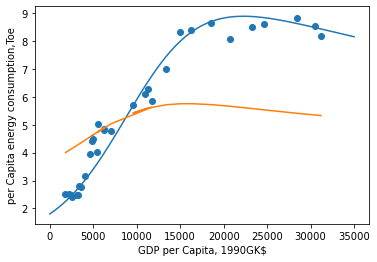

In [27]:
plt.scatter(GDP/pop, PEC/pop)
plt.plot(np.arange(35000), [wang(G) for G in np.arange(35000)])
plt.plot(G, s_curve(dict, G))
plt.xlabel('GDP per Capita, 1990GK$')
plt.ylabel('per Capita energy consumption,Toe')